In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning

pytorch_lightning.seed_everything(123)
sns.set_theme(style="whitegrid", font_scale=1.2, palette="muted")

Seed set to 123


Text(0, 0.5, '')

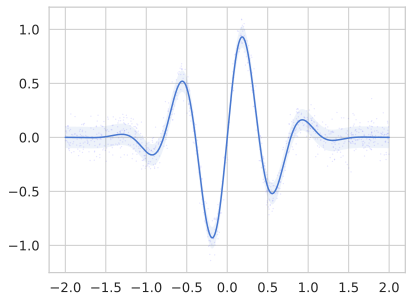

In [3]:
n = 1000
x = torch.linspace(-2, 2, 2*n)
p, q, r = 0, 2, 4
y = torch.sin(p + r * q * x) * torch.exp(-(p + r * q * x)**2/32.0)
std = 0.1

ids = np.random.choice(torch.arange(len(x)), n)
X = x[ids]
Y = y[ids] + np.random.normal(0, std, n)

dataset = torch.utils.data.TensorDataset(X.unsqueeze(1), Y.unsqueeze(1))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

sns.lineplot(x=x, y=y)
plt.fill_between(x, y - std, y + std, alpha=0.10)
sns.scatterplot(x=X, y=Y, color="blue", s=2, alpha=0.10)
plt.xlabel("")
plt.ylabel("")

In [4]:
def plot_model_predictions(model):
    model.eval()
    µ, σ = model(x.unsqueeze(1))
    µ = µ.detach().squeeze()
    σ = σ.detach().squeeze()
    sns.lineplot(x=x, y=y)
    plt.fill_between(x, y - std, y + std, alpha=0.10)
    sns.lineplot(x=x, y=µ, color="darkred")
    plt.fill_between(x, µ - σ, µ + σ, alpha=0.10, color="darkred")
    plt.xlabel("")
    plt.ylabel("")

class HeteroscedasticRegressionModel(nn.Module):
    def __init__(self, sigma_backpropagation=True):
        super(HeteroscedasticRegressionModel, self).__init__()
        self.hidden1 = nn.Linear(1, 30)
        self.hidden2 = nn.Linear(30, 50)
        self.relu = nn.ReLU()
        self.mu = nn.Linear(50, 1)
        self.sigma = nn.Linear(50, 1)
        self.sigma_backpropagation=sigma_backpropagation

    def forward(self, x):
        h = self.relu(self.hidden1(x))
        h = self.relu(self.hidden2(h))
        µ = self.mu(h)
        if not self.sigma_backpropagation:
            h = h.detach()
        σ = self.relu(self.sigma(h))
        return µ, σ

    def univariate_heteroscedastic_regression_loss(self, y_true, y_pred):
        µ, σ = y_pred
        return -torch.distributions.Normal(µ, torch.max(σ, torch.tensor(1e-6))).log_prob(y_true).mean()

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001)

    def fit(self, dataloader, epochs=1, verbose=1):
        optimizer = self.configure_optimizers()
        for epoch in range(epochs):
            self.train()
            epoch_loss = 0.0

            for X, Y in dataloader:
                optimizer.zero_grad()
                loss = self.univariate_heteroscedastic_regression_loss(Y, self(X))
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            if verbose:
                print(f"{epoch:<4} {epoch_loss}")
        self.eval()

In [5]:
model1 = HeteroscedasticRegressionModel(sigma_backpropagation=True)
model2 = HeteroscedasticRegressionModel(sigma_backpropagation=False)
model2.load_state_dict(model1.state_dict())

<All keys matched successfully>

## Conventional Heteroscedastic Regression

0    21.012530323294104
1    6.104166866716169
2    3.4237907122184206
3    1.0469951508146953
4    0.4821680066294785
5    -0.39843825092551666
6    -0.5431712719808561
7    -0.6792031735531461
8    -0.7384032394588262
9    -0.3652525076808194
10   -0.721856290106466
11   -1.109511235395976
12   -1.4728251864956476
13   -1.120411512357641
14   -0.9764533373870465
15   -1.6140311531248395
16   -1.623653472196309
17   -1.4317138567822207
18   -1.614976857671301
19   -1.8912107428242357
20   -2.0141424440843325
21   -1.8464226437027271
22   -2.2693903451283792
23   -2.0472239472671214
24   -2.421202905559907
25   -2.2913731229092043
26   -2.3933528707899385
27   -2.3483217662380875
28   -2.192257766666309
29   -2.597009386757221
30   -2.5433035213470907
31   -2.3140486396314017
32   -2.4632538749304285
33   -2.226231082044216
34   -2.0380503915162618
35   -2.868008262338739
36   -2.5511561183577935
37   -2.5084628766675063
38   -2.4882318202532216
39   -2.6974138709267765
40   -2.6837672

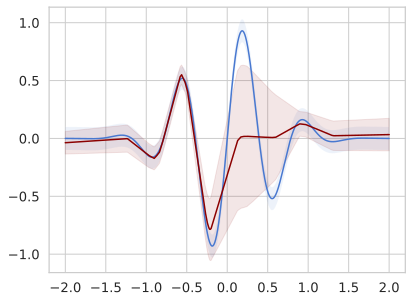

In [6]:
model1.fit(dataloader, epochs=200)
plot_model_predictions(model1)

## Heteroscedastic Regression with modified backpropagation

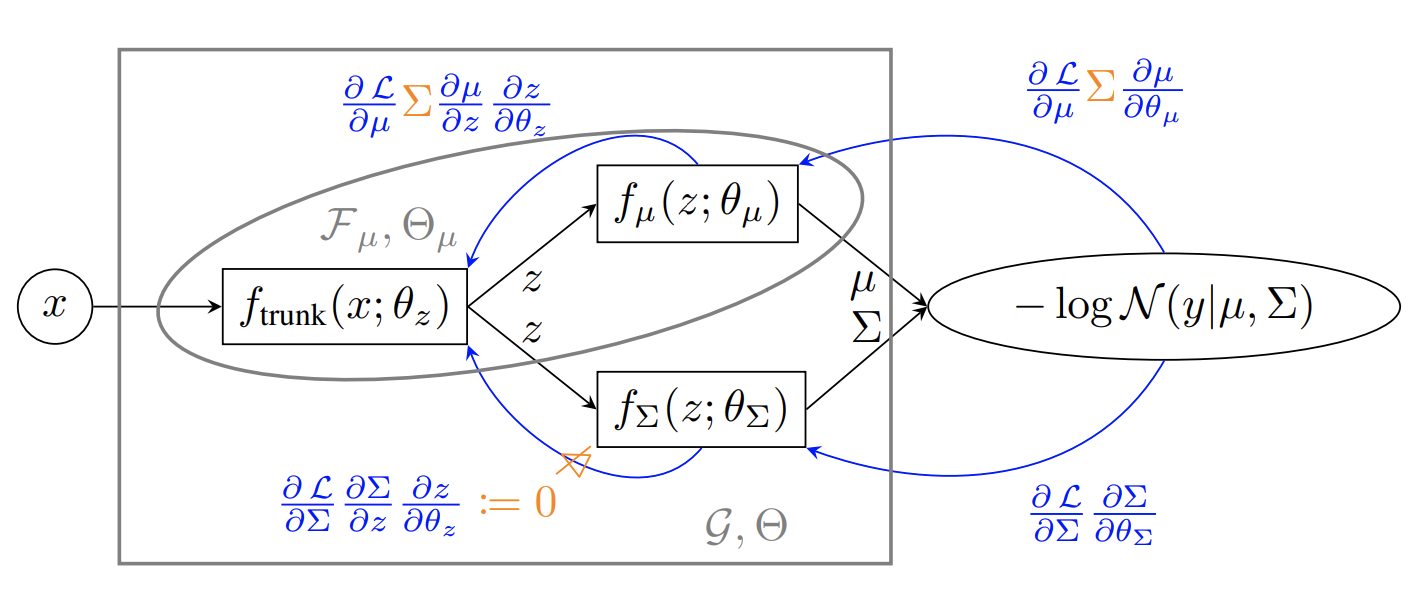

0    48.18615940762022
1    14.695724383512033
2    11.066192162510735
3    9.578587879762292
4    8.229735320955218
5    6.903129837678502
6    5.865516162594922
7    4.932453372595972
8    3.6921446213093962
9    2.775367368295826
10   1.7736642301288406
11   1.3595789616935439
12   1.0045876483206475
13   0.6958939149748777
14   0.5308562537580839
15   0.30246318293323937
16   0.18596138890731528
17   0.36823451843548816
18   0.3070557784474465
19   -0.22473657195889687
20   -0.2081674735486279
21   -0.240078224105481
22   -0.5645193542657972
23   -0.43212168677301205
24   -0.6776657337044099
25   -0.5187518244102928
26   -0.6316382226505732
27   -0.5512025271804399
28   -0.7962909475148057
29   -0.9579443367874099
30   -1.1282792297937392
31   -1.228845699672474
32   -1.1979960201178763
33   -1.4272596513397275
34   -1.4817238931040897
35   -1.247010380389193
36   -1.4218887056883511
37   -1.5511776402836612
38   -1.5182526076417664
39   -1.5763793225715845
40   -1.7802340763354398

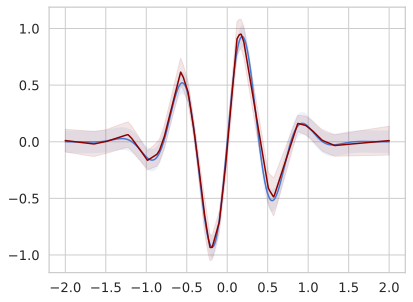

In [7]:
model2.fit(dataloader, epochs=200)
plot_model_predictions(model2)